In [5]:
from helpers import *
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries to create the multiclass model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

#Library to validate the model
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
df = pd.read_csv("data_moods.csv")

In [7]:
col_features = df.columns[6:-3]
X= MinMaxScaler().fit_transform(df[col_features])
X2 = np.array(df[col_features])
Y = df['mood']

In [8]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)


#Convert to  dummy (Not necessary in my case)
dummy_y = np_utils.to_categorical(encoded_y)

X_train,X_test,Y_train,Y_test = train_test_split(X,encoded_y,test_size=0.2,random_state=15)

target = pd.DataFrame({'mood':df['mood'].tolist(),'encode':encoded_y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

,mood,encode
5,Calm,0
4,Energetic,1
0,Happy,2
1,Sad,3


In [9]:
def base_model():
    #Create the model
    model = Sequential()
    #Add 1 layer with 8 nodes,input of 4 dim with relu function
    model.add(Dense(8,input_dim=10,activation='relu'))
    #Add 1 layer with output 3 and softmax function
    model.add(Dense(4,activation='softmax'))
    #Compile the model using sigmoid loss function and adam optim
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

In [25]:
estimator = KerasClassifier(build_fn=base_model,epochs=300,batch_size=200,verbose=0)


In [26]:
#Evaluate the model using KFold cross validation
kfold = KFold(n_splits=10,shuffle=True)
results = cross_val_score(estimator,X,encoded_y,cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

Baseline: 78.86% (5.19%)


In [27]:
estimator.fit(X_train,Y_train)
y_preds = estimator.predict(X_test)

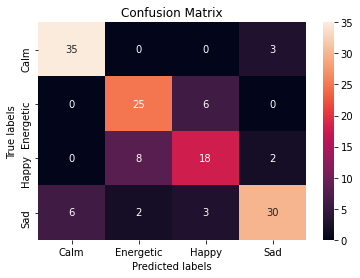

Accuracy Score 0.782608695652174


In [28]:
cm = confusion_matrix(Y_test,y_preds)
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)

labels = target['mood']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print("Accuracy Score",accuracy_score(Y_test,y_preds))

In [29]:
import spotipy
import time
from IPython.core.display import clear_output
from spotipy import SpotifyClientCredentials, util

client_id='xxxxx'
client_secret='xxxx'
# redirect_uri='your_url_to_redirect'
# username = 'your_username_spotify_code'
# scope = 'playlist-modify-public'

#Credentials to access the Spotify Music Data
manager = SpotifyClientCredentials(client_id,client_secret)
sp = spotipy.Spotify(client_credentials_manager=manager)

In [30]:
def get_songs_features(ids):

    meta = sp.track(ids)
    features = sp.audio_features(ids)

    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    popularity = meta['popularity']
    ids =  meta['id']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    valence = features[0]['valence']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    key = features[0]['key']
    time_signature = features[0]['time_signature']

    track = [name, album, artist, ids, release_date, popularity, length, danceability, acousticness,
            energy, instrumentalness, liveness, valence, loudness, speechiness, tempo, key, time_signature]
    columns = ['name','album','artist','id','release_date','popularity','length','danceability','acousticness','energy','instrumentalness',
                'liveness','valence','loudness','speechiness','tempo','key','time_signature']
    return track,columns

In [31]:
def predict_mood(id_song):
    #Join the model and the scaler in a Pipeline
    pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
                                                                             batch_size=200,verbose=0))])
    #Fit the Pipeline
    pip.fit(X2,encoded_y)

    #Obtain the features of the song
    preds = get_songs_features(id_song)
    #Pre-process the features to input the Model
    preds_features = np.array(preds[0][6:-2]).reshape(-1,1).T

    #Predict the features of the song
    results = pip.predict(preds_features)

    mood = np.array(target['mood'][target['encode']==int(results)])
    name_song = preds[0][0]
    artist = preds[0][2]

    return print("{0} by {1} is a {2} song".format(name_song,artist,mood[0].upper()))
    #print(f"{name_song} by {artist} is a {mood[0].upper()} song")

In [32]:
predict_mood('0VjIjW4GlUZAMYd2vXMi3b')


Blinding Lights by The Weeknd is a ENERGETIC song
